# 설정값 지정

## 필요한 라이브러리

In [1]:
import os
import yaml

In [2]:
class Config(dict):
    def __init__(self, config_path):
        with open(config_path, 'r') as f:
            self._yaml = f.read()
            self._dict = yaml.load(self._yaml)
            self._dict['PATH'] = os.path.dirname(config_path)

    def __getattr__(self, name):
        if self._dict.get(name) is not None:
            return self._dict[name]

        if DEFAULT_CONFIG.get(name) is not None:
            return DEFAULT_CONFIG[name]

        return None

    def print(self):
        print('Model configurations:')
        print('---------------------------------')
        print(self._yaml)
        print('')
        print('---------------------------------')
        print('')
        
DEFAULT_CONFIG = {
    'MODE': 1,                      # 1: train, 2: test, 3: eval
    'MODEL': 1,                     # 1: edge model, 2: inpaint model, 3: edge-inpaint model, 4: joint model
    'MASK': 3,                      # 1: random block, 2: half, 3: external, 4: (external, random block), 5: (external, random block, half)
    'EDGE': 1,                      # 1: canny, 2: external
    'NMS': 1,                       # 0: no non-max-suppression, 1: applies non-max-suppression on the external edges by multiplying by Canny
    'SEED': 10,                     # random seed
    'GPU': [0],                     # list of gpu ids
    'DEBUG': 0,                     # turns on debugging mode
    'VERBOSE': 0,                   # turns on verbose mode in the output console
    
    'LR': 0.0001,                   # learning rate
    'D2G_LR': 0.1,                  # discriminator/generator learning rate ratio
    'BETA1': 0.0,                   # adam optimizer beta1
    'BETA2': 0.9,                   # adam optimizer beta2
    'BATCH_SIZE': 8,                # input batch size for training
    'INPUT_SIZE': 256,              # input image size for training 0 for original size
    'SIGMA': 2,                     # standard deviation of the Gaussian filter used in Canny edge detector (0: random, -1: no edge)
    'MAX_ITERS': 2e6,               # maximum number of iterations to train the model

    'EDGE_THRESHOLD': 0.5,          # edge detection threshold
    'L1_LOSS_WEIGHT': 1,            # l1 loss weight
    'FM_LOSS_WEIGHT': 10,           # feature-matching loss weight
    'STYLE_LOSS_WEIGHT': 1,         # style loss weight
    'CONTENT_LOSS_WEIGHT': 1,       # perceptual loss weight
    'INPAINT_ADV_LOSS_WEIGHT': 0.01,# adversarial loss weight

    'GAN_LOSS': 'nsgan',            # nsgan | lsgan | hinge
    'GAN_POOL_SIZE': 0,             # fake images pool size

    'SAVE_INTERVAL': 1000,          # how many iterations to wait before saving model (0: never)
    'SAMPLE_INTERVAL': 1000,        # how many iterations to wait before sampling (0: never)
    'SAMPLE_SIZE': 12,              # number of images to sample
    'EVAL_INTERVAL': 0,             # how many iterations to wait before model evaluation (0: never)
    'LOG_INTERVAL': 10,             # how many iterations to wait before logging training status (0: never)
    'SEG_NETWORK': 0,               # 0:DeepLabV3 resnet 101 segmentation , 1: MASK-R-CNN resnet 101 segmentation
}

# 데이터셋 함수

- data폴더 내에 있는 이미지 파일들로 Segmentation과 Inpainting을 수행할 예정이고, 두 과업은 각각 Pretrained된 모델을 가져와서 사용할 것이다. 또한 위에서 지정한 변수값들을 지정할 것이다.

### 필요한 라이브러리

In [3]:
import cv2
import glob
import torch
import random
import numpy as np
from PIL import Image
from imageio import imread
from skimage.feature import canny
from torch.utils.data import DataLoader
from src.utils import create_mask
from skimage.color import rgb2gray, gray2rgb
import torchvision.transforms.functional as F

In [4]:
class EdgeConnectDataset(torch.utils.data.Dataset):
    def __init__(self, config, flist, edge_flist, augment = True, 
                 training = True):
        super(EdgeConnectDataset, self).__init__()
        self.augment = augment
        self.training = training
        self.data = self.load_flist(flist)
        self.edge_data = self.load_flist(edge_flist)
        
        self.input_size = config.INPUT_SIZE
        self.sigma = config.SIGMA
        self.edge = config.EDGE
        self.mask = config.MASK
        self.nms = config.NMS
        self.device = config.SEG_DEVICE
        self.objects = config.OBJECTS
        self.segment_net = config.SEG_NETWORK
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        try:
            item = self.load_item(index)
        except:
            print('loading error : ' + self.data[index])
            item = self.load_item(0)
            
        return item
    
    def load_item(self, index):
        size = self.input_size
        
        # load image
        img = Image.open(self.data[index])
        
        # gray to rgb
        if img.mode != 'RGB':
            img = gray2rgb(np.array(img))
            img = Image.fromarray(img)
            
        # resize / crop if needed
        img, mask = segmentor(self.segment_net, img, self.device, self.objects)
        img = Image.fromarray(img)
        img = np.array(img.resize((size, size), Image.ANTIALIAS))
        
        # create grayscale image
        img_gray = rgb2gray(np.array(img))
        
        # load mask
        mask = Image.fromarray(mask)
        mask = np.array(mask.resize((size, size), Image.ANTIALIAS))
        idx = (mask > 0)
        mask[idx] = 255
        mask = np.apply_along_axis(fill_gaps, 1, mask) # horizontal padding
        mask = np.apply_along_axis(fill_gaps, 0, mask) # vertical padding
        
        # load edge
        edge = self.load_edge(img_gray, index, mask)
            
        # augment data
        if self.augment and np.random.binomial(1, 0.5) > 0:
            img = img[:, ::-1, ...]
            img_gray = img_gray[:, ::-1, ...]
            edge = edge[:, ::-1, ...]
            mask = mask[:, ::-1, ...]
            
        return self.to_tensor(img), self.to_tensor(img_gray), \
                self.to_tensor(edge), self.to_tensor(mask)
    
    def load_edge(self, img, index, mask):
        sigma = self.sigma
        
        '''
        In test mode, images are masked(with masked regions),
        using 'mask' parameter prevents canny to detect edges for the masked
        regions
        '''
        mask = None if self.training else (1 - mask / 255).astype(np.bool)
        
        # canny
        if self.edge == 1:
            # no edge
            if sigma == -1:
                return np.zeros(img.shape).astype(np.float)
            
            # random sigma
            if sigma == 0:
                sigma = random.randint(1, 4)
                
            return canny(img, sigma = sigma, mask = mask).astype(np.float)
        # external
        else:
            img_h, img_w = img.shapepe[:2]
            edge = imread(self.edge_data[index])
            edge = self.resized(edge, img_h, img_w)
            
            # Non-Max Suppression
            if self.nms == 1:
                edge = edge * canny(img, sigma = sigma, mask = mask)
                
            return edge
        
    
    def to_tensor(self, img):
        img = Image.fromarray(img)
        img_t = F.to_tensor(img).float()
        
        return img_t
    
    def load_flist(self, flist):
        if isinstance(flist, list):
            return flist
        
        # flist : image file path, image directory path, text file flist path
        if isinstance(flist, str):
            if os.path.isdir(flist):
                flist = list(glob.glob(flist + '/.jpg'))
                flist.sort()
                
                return flist
            
            if os.path.isfile(flist):
                try:
                    return np.genfromtxt(flist, dtype = np.str, 
                                         encoding = 'utf-8')
                except:
                    return [flist]
                
        return []
    
    def create_iterator(self, batch_size):
        while True:
            sample_loader = DataLoader(
                dataset = self,
                batch_size = batch_size,
                drop_last = True
            )
            
            for item in sample_loader:
                yield item

# Segmentation 수행
- Segmentation에는 Semantic Segmentation과 Instance Segmentation이 있다.
- Semantic Segmentation은 이미지 내 모든 Object들에 대해 Instance(person1, person2, ...)를 구분하지 않고 특정 class에 속하는 Object들 모두 같게 Segmentation을 수행한다.
- Instance Segmentation은 이미지 내 모든 Object들에 대해 Instance를 구분해서 특정 class에 속하는 Object들 중 Instance별로 다르게 Segmentation을 수행하다.

## Semantic Segmentation 모델
- pretrained된 모델로 FCN(Fully Convolution Network)과 DeeplabV3모델을 사용해서 Semantic Segmentation을 수행할 것이다.

## 필요한 라이브러리

In [5]:
from src.utils import Progbar, create_dir, stitch_images, imsave
from torchvision import models
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

In [6]:
fcn = models.segmentation.fcn_resnet101(pretrained = True).eval()
dlab = models.segmentation.deeplabv3_resnet101(pretrained = True).eval()

# Instance Segmentation 모델
- pretrained된 모델로 Mask-R-CNN모델을 사용해서 Instance Segmentation을 수행할 것이다.

In [7]:
mask_r_cnn = models.detection.maskrcnn_resnet50_fpn(pretrained = 1, 
                                                    progress = False).eval()

In [8]:
def decode_segmap(image,objects,nc=21):
                
    r = np.zeros_like(image).astype(np.uint8)
    for l in objects:
        idx = image == l
        r[idx] = 255#fill  r with 255 wherever class is 1 and so on
    return np.array(r)

In [9]:
def fill_gaps(values):
    searchval=[255,0,255]
    searchval2=[255,0,0,255]
    idx=(np.array(np.where((values[:-2]==searchval[0]) & (values[1:-1]==searchval[1]) & (values[2:]==searchval[2])))+1)
    idx2=(np.array(np.where((values[:-3]==searchval2[0]) & (values[1:-2]==searchval2[1]) & (values[2:-1]==searchval2[2]) & (values[3:]==searchval2[3])))+1)
    idx3=(idx2+1)
    new=idx.tolist()+idx2.tolist()+idx3.tolist()
    newlist = [item for items in new for item in items]
    values[newlist]=255
    return values

In [10]:
def fill_gaps2(values):
    searchval=[0,255]
    searchval2=[255,0]
    idx=(np.array(np.where((values[:-1]==searchval[0]) & (values[1:]==searchval[1]))))
    idx2=(np.array(np.where((values[:-1]==searchval[0]) & (values[1:]==searchval[1])))+1)
    
    new=idx.tolist()+idx2.tolist()
    newlist = [item for items in new for item in items]
    values[newlist]=255
    return values

In [11]:
def fill_gaps2(values):
    searchval=[0,255]
    searchval2=[255,0]
    idx=(np.array(np.where((values[:-1]==searchval[0]) & (values[1:]==searchval[1]))))
    idx2=(np.array(np.where((values[:-1]==searchval[0]) & (values[1:]==searchval[1])))+1)
    
    new=idx.tolist()+idx2.tolist()
    newlist = [item for items in new for item in items]
    values[newlist]=255
    return values

# 이미지 전처리
- 테스트 이미지이지만 데이터 수가 적기 때문에 데이터 확대 기법을 적용해서 많은 이미지로 과업들을 수행할 수 있도록 하려 했으나 pretrained된 모델로 과업을 수행할 계획이라 전처리 기법을 많이 적용하지 않을 예정이다.
- PyTorch에서 제공하는 transforms모듈 내에서 Resize, ToTensor, Normalize함수를 이용해 테스트 이미지들에 대한 전처리를 수행한다.
- 백지연

In [12]:
def segmentor(seg_net,img,dev,objects):
    #plt.imshow(img); plt.show()
    if seg_net == 1:
        net = mask_r_cnn
    else:
        net = dlab
    if dev == 'cuda':
        trf = T.Compose([T.Resize(400),
                         T.ToTensor(), 
                         T.Normalize(mean = [0.485, 0.456, 0.406], 
                                    std = [0.229, 0.224, 0.225])])
    else:
        trf = T.Compose([T.Resize(680),
                         T.ToTensor(), 
                         T.Normalize(mean = [0.485, 0.456, 0.406], 
                                     std = [0.229, 0.224, 0.225])])
        
    inp = trf(img).unsqueeze(0).to(dev)
    out = net.to(dev)(inp)['out']
    om = torch.argmax(out.squeeze(), dim = 0).detach().cpu().numpy()
    mask = decode_segmap(om,objects)
    height,width = mask.shape
    img = np.array(img.resize((width, height), Image.ANTIALIAS))


    og_img = remove_patch_og(img,mask)
    plt.imshow(mask); plt.show()
    
    return og_img,mask

In [13]:
# 설정값 파일 경로
config_path = os.path.join('./checkpoints', 'config.yml')

# 설정값 파일 가져오기
config = Config(config_path)

# 전체 테스트 데이터셋
test_dataset = EdgeConnectDataset(config, config.TEST_FLIST, config.TEST_EDGE_FLIST,
                            augment = False, training = False)

test_loader = DataLoader(dataset = test_dataset, batch_size = 1)  

c:\users\rudck\anaconda3\envs\inpainting\lib\site-packages\ipykernel_launcher.py:5: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  """


# 변수값 지정

In [14]:
test_batch_size = 1

no_cuda = False

# 전체 테스트 데이터 저장경로
test_data_paths = glob.glob('data/*.jpg')

# 랜덤 인덱스 이용해 랜덤 이미지로 과업 수행
rnd_test_datas = np.random.choice(test_data_paths, 3)
print(rnd_test_datas)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

['data\\train_1.jpg' 'data\\cat_2.jpg' 'data\\cat_4.jpg']


In [15]:
transforms_lst = transforms.Compose([
    transforms.Resize(400),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

In [16]:
def get_label(path):
    return os.path.basename(path).split('_')[0]

In [17]:
label_names = [get_label(path) for path in test_data_paths]
classes = np.unique(label_names)
classes

array(['TVmonitor', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle',
       'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse',
       'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train'],
      dtype='<U11')

In [18]:
class customDataset(torch.utils.data.Dataset):
    def __init__(self, data_paths, transform = None):
        self.data_paths = data_paths
        self.transform = transform
        
    def __len__(self):
        return len(self.data_paths)
    
    def __getitem__(self, idx):
        path = self.data_paths[idx]
        
        # Read image
        image_pil = Image.open(path)
        
        if self.transform:
            image = self.transform(image_pil)
            
        return image

In [19]:
use_cuda = not no_cuda and torch.cuda.is_available()
kwargs = {'num_workers' : 0, 'pin_memory' : True} if use_cuda else {}

In [20]:
test_loader = torch.utils.data.DataLoader(
    customDataset(rnd_test_datas, transforms_lst),
    batch_size = test_batch_size,
    shuffle = False,
    **kwargs
)

In [21]:
# fcn = models.segmentation.fcn_resnet101(pretrained = True).eval()
dlab = models.segmentation.deeplabv3_resnet101(pretrained = True).eval()

In [22]:
image_path = rnd_test_datas[random.randrange(0, len(rnd_test_datas))]
image_path

'data\\train_1.jpg'

In [32]:
image_pil = Image.open(image_path)
image = np.array(image_pil)
image.shape

(682, 1024, 3)

In [24]:
# input_image = transforms_lst(image_pil).unsqueeze(0).to(device)
# output = fcn.to(device)(input_image)['out']
# output_max = torch.argmax(output.squeeze(), dim = 0).detach().cpu().numpy()

# plt.imshow(output_max)
# plt.show()

c:\users\rudck\anaconda3\envs\inpainting\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


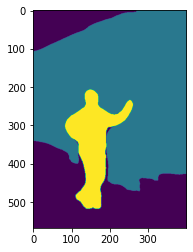

In [25]:
input_image = transforms_lst(image_pil).unsqueeze(0).to(device)
output = dlab.to(device)(input_image)['out']
output_max = torch.argmax(output.squeeze(), dim = 0).detach().cpu().numpy()

plt.imshow(output_max)
plt.show()

In [33]:
input_image = transforms_lst(image_pil).unsqueeze(0).to(device)
output = mask_r_cnn.to(device)(input_image)['out']
output_max = torch.argmax(output.squeeze(), dim = 0).detach().cpu().numpy()

plt.imshow(output_max)
plt.show()

c:\users\rudck\anaconda3\envs\inpainting\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


TypeError: list indices must be integers or slices, not str

In [26]:
def decode_segmap(image,objects,nc=21):
                
    r = np.zeros_like(image).astype(np.uint8)
    for l in objects:
        idx = image == l
        r[idx] = 255#fill  r with 255 wherever class is 1 and so on
    return np.array(r)

In [27]:
def remove_patch_og(real_img,mask):
    og_data = real_img.copy()
    idx = mask == 255  ### cutting out mask part from real image here
    og_data[idx] =255
    return og_data

In [ ]:
sem_classes = [
    '__background__', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor'
]
sem_class_to_idx = {cls: idx for (idx, cls) in enumerate(sem_classes)}

In [ ]:
from torchvision.models.detection import maskrcnn_resnet50_fpn

mask_r_cnn = maskrcnn_resnet50_fpn(pretrained = True, progress = False)
mask_r_cnn = mask_r_cnn.eval()

output = mask_r_cnn(batch)
output

In [ ]:
inst_classes = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

inst_class_to_idx = {cls : idx for (idx, cls) in enumerate(inst_classes)}

In [ ]:
len(output)

In [ ]:
person_output, bicycle_output = output[0], output[1]
person_masks, bicycle_masks = person_output['masks'], bicycle_output['masks']
print(f'shape = {person_masks.shape}, dtype = {bicycle_masks.dtype}, '
      f'min = {person_masks.min()}, max = {bicycle_masks.max()}')

In [ ]:
inst_classes = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

inst_class_to_idx = {cls : idx for (idx, cls) in enumerate(inst_classes)}

print('For the first person, the following instances were detected : ')
print([inst_classes[label] for label in person_output['labels']])

In [ ]:
proba_threshold = 0.5
person_bool_masks = person_output['masks'] > proba_threshold
print(f'shape = {person_bool_masks.shape}, dtype = {person_bool_masks.dtype}')

person_bool_masks = person_bool_masks.squeeze(1)

show(draw_segmentation_masks(person1_int, person_bool_masks, alpha = 0.9))

In [ ]:
bicycle_bool_masks = bicycle_output['masks'] > proba_threshold
print(f'shape = {bicycle_bool_masks.shape}, dtype = {bicycle_bool_masks.dtype}')

bicycle_bool_masks = bicycle_bool_masks.squeeze(1)

show(draw_segmentation_masks(bicycle1_int, bicycle_bool_masks, alpha = 0.9))

# Inpainting 수행